In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
import ast
import statsmodels.api as sm
from scipy import stats
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [21]:
#USC fbbb & fbonly
#4个tag每个跑5张roc5张feature importance和5组score data

# Choose the Organization of Interest

In [22]:
org = "USC"

# Load Account Data

In [23]:
# Load Account Data For a Specific Organization

account = pd.read_csv("acc_tags_set.csv")
account = account[account.org_id==org].copy()
account.drop(columns = ["nan_tag"], inplace = True)

interested_tags = set()
acc_tag_dict = defaultdict(int)
for i in range(len(account)):
    tag_list = ast.literal_eval(account.tags.iloc[i])
    for t in tag_list:
        acc_tag_dict[t]+=1
        interested_tags.add(t)
account_per_tag = []
for k,v in acc_tag_dict.items():
    account_per_tag.append({"tag":k,"counts":v })
account_per_tag = pd.DataFrame(account_per_tag)

# Load Seasonal Ticket Data

In [24]:
ticket_season = pd.read_csv("USC_ticket_trans_item_event.csv")

In [25]:
ticket_season = ticket_season[ticket_season.org_id.isin([org])].copy()
ticket_orgs = ticket_season.org_id.unique()

# Preprocess Data

## Only select the tags that have been assigned to more than 100 accounts

In [26]:
useful_tags = []
error_tags = []
# method = "logit"

for i,tag in enumerate(interested_tags):
    if type(tag)==str and account_per_tag[account_per_tag.tag==tag].iloc[0]["counts"] >100:
        useful_tags.append(tag)

## Pivot Wide Table so that each column is a season of the organization

In [27]:
ticket_season_org = ticket_season[["account_id","org_id","season","total_epay",
                                   "e_oqty"]].groupby(["account_id","org_id",
                                                       "season"]).sum().reset_index()
ticket_season_org = ticket_season_org.pivot(index = ["account_id","org_id"], 
                           columns = ["season"],
                           values = ["total_epay","e_oqty"]).fillna(0)
ticket_season_org.columns = ["_".join(x) if x[0] not in ["account_id","org_id"] else x[0] for x in ticket_season_org.columns.ravel()]
temp = pd.merge(account,ticket_season_org, on = ["account_id","org_id"], how = "inner")
temp.fillna(0,inplace = True)

# Random Forest

In [28]:
def get_roc(testy, pred_y, org , tag):
    ns_probs = [0 for _ in range(len(testy))]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    rf_auc = roc_auc_score(testy, pred_y)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Random Forest: ROC AUC=%.3f' % (rf_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    rf_fpr, rf_tpr, _ = roc_curve(testy, pred_y)
    return rf_auc,ns_fpr, ns_tpr,rf_fpr, rf_tpr

def plot_roc(ns_fpr, ns_tpr,rf_fpr, rf_tpr, tag, org):
    
    colors = ["#2CBDFE","#47DBCD","#F3A0F2","#9D2EC5","#F5B14C"]
    # plot the roc curve for the model
    for i,(lf, lt,color) in enumerate(zip(rf_fpr, rf_tpr, colors)):      
        pyplot.plot(lf, lt, marker='.', label=f'CV {i+1}', color=color )
    pyplot.plot(ns_fpr[0], ns_tpr[0], linestyle='dashdot', label='random forest',color = "black")
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    
    pyplot.title(f"ROC Curve for Tag {tag} in {org}")
    # save image
    pyplot.savefig(f'{org}_{tag}.png',bbox_inches='tight')
    
    # show the plot
    
    pyplot.show()
#     return lr_auc

In [29]:
def calculate_season_slm(tag,org):
    '''Get 5-fold Cross Validation Result for Logistic Regression in predicting whether the accounts
    in a selected organization are assigned a selected tag.
    Get the account and ticket data from previous codes to avoid copying too many data and crashing the session
    '''
    print("Selected Tag:", tag)
#     ----------------------------------Preprocess Data ----------------------------------
#     Ticket Season: Number of Columns
    print("old columns number:",len(ticket_season_org.columns))
    
#     Account Data: Create Target Column to indicate whether and again return 0 if 
    tag_account = account.copy()
    tag_account["tag"] = tag_account.tags.str.contains(tag).fillna(False)
    tag_num = len(tag_account[tag_account.tag])
    if tag_num<100:
        return 0
    
#     Merge Account + Ticket Season    
    temp = pd.merge(tag_account,ticket_season_org, on = ["account_id","org_id"], how = "left")
    total_number_of_account = len(temp)
    total_number_of_acc_w_tag = len(temp[temp.tag])
    print("total number of accounts labeled with tag:", total_number_of_acc_w_tag)
    print("total number of accounts: ",total_number_of_account)
    print("percentage of tags:",total_number_of_acc_w_tag/total_number_of_account)
    
    if len(temp[temp.tag])<100:     
        return 0
    
    temp.fillna(0,inplace = True)   
    
#     Drop Season Columns if fewer than 1000 accounts have bought relevant tickets:
    temp["intercept"] = 1
    temp.drop(columns = ["tags"], inplace = True)
    drop_cols = []
    for c in temp.columns:
        if c not in ["account_id","org_id",'tag']:
            if len(temp[temp[c]>0])<1000:
                drop_cols.append(c)
    print(drop_cols)
    temp.drop(columns = drop_cols, inplace = True)
    
#     The X variable Columns
    xs = [c for c in temp.columns if c not in ["account_id","org_id",'tag']]
    print("new columns number:",len(xs))

#     Randomize the dataframe with sample and fraction = 1 and replace = False
    np.random.seed(0)
    temp = temp.sample(frac=1).reset_index(drop=True)
    
#     random forest
    overall_result=RandomForestClassifier().fit(temp[xs],temp.tag)
    
#    -------------------------------------------------------------------------------------------    
#     ------------------5-FOLD Cross Validation Data Preprocess-------------------

#     Split the data with tag from no tag for future 5-fold splitting
    temp_tag = temp[temp.tag].copy()
    temp = temp[~temp.tag]

#     # Tags Train Split - index
    arr_tags = np.arange(len(temp_tag))
    np.random.seed(0)
    np.random.shuffle(arr_tags)
    arr_tags=np.array_split(arr_tags, 5)
    
#     # Not Tags Train Split - index
    arr_no_tags = np.arange(len(temp))
    np.random.seed(0)
    np.random.shuffle(arr_no_tags)
    arr_no_tags=np.array_split(arr_no_tags, 5)
    
    temp.reset_index(inplace = True)
    temp_tag.reset_index(inplace = True)

#     ------------------5-FOLD Cross Validation and Metrics-------------------
    
    average_mse =0
    avg_specificity = 0
    avg_sensitivity = 0
    avg_f1 = 0
    sense_gd=True
    spec_gd = True
    avg_auc_score=0
    ns_fprs, ns_tprs,lr_fprs, lr_tprs = [],[],[],[]
    for i,(ari1, ari2) in enumerate(zip(arr_no_tags, arr_tags)):
#         Train Test split using the previously prepared indexes in each fold
        temp_test = pd.concat([temp.iloc[ari1],
                             temp_tag.iloc[ari2]]).reset_index()
        temp_tr = pd.concat([temp.drop(ari1,axis =0),
                               temp_tag.drop(ari2,axis =0)])
        temp_tr = temp_tr.sample(frac=1).reset_index(drop=True)

#       Train random forest Model 
        result=RandomForestClassifier().fit(temp_tr[xs],temp_tr.tag)
        
        sorted_idx = result.feature_importances_.argsort()
        plt.barh([xs[c] for c in sorted_idx], result.feature_importances_[sorted_idx])
        plt.xlabel("Random Forest Feature Importance")
        plt.show()
        predicted = result.predict_proba(temp_test[xs])[:,1]
        
#        Calculate auc score and plot roc curve

        auc_score, ns_fpr,ns_tpr,lr_fpr,lr_tpr = get_roc(temp_test.tag,predicted,org,tag)
        ns_fprs.append(ns_fpr)
        ns_tprs.append(ns_tpr)
        lr_tprs.append(lr_tpr)
        lr_fprs.append(lr_fpr)
        avg_auc_score+=auc_score
        
#           Use 0.5 as threshold: <0.5 means no tag; >=0.5 means tag
        predicted = np.where(predicted<0.5,0,1)
        
#         Calculate Measure Metrics:
#       mse, true_positive, false_negative,true_negative,false_positive
        mse = np.sum((predicted - temp_test.tag)**2)/len( temp_test.tag)

        average_mse+=mse
        true_positive = 0
        false_negative = 0
        true_negative = 0
        false_positive= 0
        
        for i in range(len(predicted)):
            if predicted[i] and temp_test.tag.iloc[i]:
                true_positive+=1
            elif not predicted[i] and not temp_test.tag.iloc[i]:
                true_negative+=1
            elif predicted[i] and not temp_test.tag.iloc[i]:
                false_negative+=1
            else:
                false_positive+=1
        print(true_positive,false_negative,true_negative,false_positive)
        if true_positive+false_negative!=0:
            sensitivity = true_positive/(true_positive+false_negative)
            avg_sensitivity+=sensitivity
#             print(i,"sensitivity:",sensitivity)
        else:
            sense_gd=False
        if true_negative+false_positive!=0:
            specificity = true_negative/(true_negative+false_positive) 
            avg_specificity+=specificity
#             print(i,"specificity:",specificity)
        else:
            spec_gd = False
            
        avg_f1 += true_positive/(true_positive+(false_positive+false_negative)/2)

    plot_roc(ns_fprs,ns_tprs,lr_fprs,lr_tprs,tag,org)
    if sense_gd:
        avg_sensitivity = avg_sensitivity/5
        print("avg_sensitivity:",avg_sensitivity)
    if spec_gd:
        avg_specificity = avg_specificity/5
        print("avg_specificity:",avg_specificity)
        
    avg_f1 = avg_f1/5
    print("avg_f1 score:", avg_f1)
              
    average_mse = average_mse/5
    print("average_mse score:", average_mse)
    
    avg_auc_score = avg_auc_score/5
    print("avg_auc_score:",avg_auc_score)
    
    result = {"overall_result":overall_result, 
              #"prsquared": overall_result.prsquared, 
              "total_number_of_account":total_number_of_account,
              "total_number_of_acc_w_tag":total_number_of_acc_w_tag,
              "Percentage of Tag": total_number_of_acc_w_tag/total_number_of_account,
              "Correct Percentage":average_mse,
              "avg_f1":avg_f1,
              "avg_auc":avg_auc_score,
              "avg_sensitivity":avg_sensitivity,
              "avg_specificity":avg_specificity,
              "sense_gd":sense_gd, 
              "spec_gd":spec_gd}
    #print("feature importance plot:", feature_importance(result))
    return result

fbbb
Selected Tag: fbbb
old columns number: 96
total number of accounts labeled with tag: 581
total number of accounts:  168481
percentage of tags: 0.0034484600637460605
['total_epay_AE17', 'total_epay_AE18', 'total_epay_AE19', 'total_epay_AE20', 'total_epay_B15', 'total_epay_B16', 'total_epay_B17', 'total_epay_B19T', 'total_epay_BS17', 'total_epay_BS18', 'total_epay_BS19', 'total_epay_CE14', 'total_epay_CE16', 'total_epay_CEF18', 'total_epay_CEF19', 'total_epay_CES18', 'total_epay_CES19', 'total_epay_CES20', 'total_epay_F14', 'total_epay_F16', 'total_epay_F17', 'total_epay_GC13', 'total_epay_GC14', 'total_epay_GC17', 'total_epay_GC18', 'total_epay_GC19', 'total_epay_PB16', 'total_epay_PB17', 'total_epay_PB19', 'total_epay_PF17', 'total_epay_PF18', 'total_epay_PF19', 'total_epay_PICF20', 'total_epay_PO17', 'total_epay_POS18', 'total_epay_POS19', 'total_epay_R18', 'total_epay_R19', 'total_epay_S18', 'total_epay_S19', 'total_epay_VB17', 'total_epay_VB18', 'total_epay_VB19', 'e_oqty_AE17'

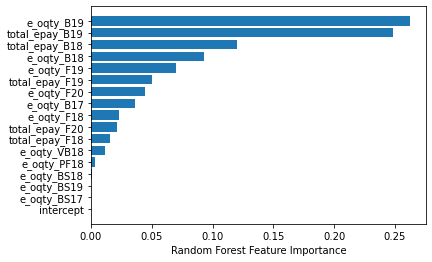

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=1.000
110 4 33576 7


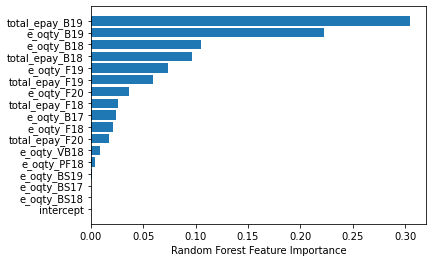

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=1.000
110 7 33573 6


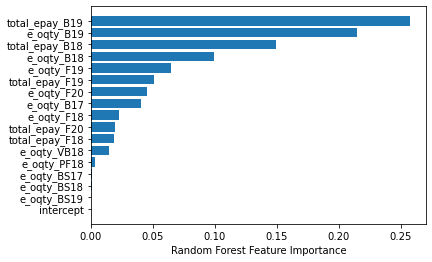

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=1.000
111 11 33569 5


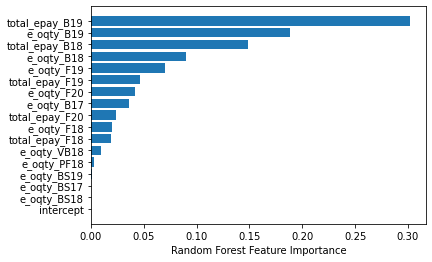

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=1.000
110 8 33572 6


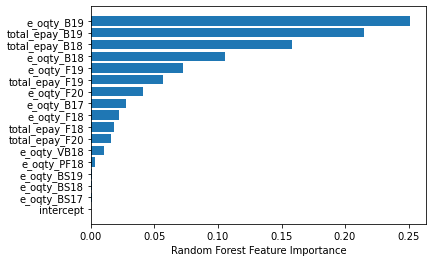

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=1.000
111 8 33572 5


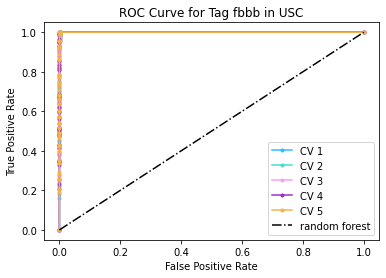

avg_sensitivity: 0.9359791571041344
avg_specificity: 0.9998272706907295
avg_f1 score: 0.9428423722886222
average_mse score: 0.00039767137678920134
avg_auc_score: 0.9999201821639232
fbonly
Selected Tag: fbonly
old columns number: 96
total number of accounts labeled with tag: 6666
total number of accounts:  168481
percentage of tags: 0.03956529222879731
['total_epay_AE17', 'total_epay_AE18', 'total_epay_AE19', 'total_epay_AE20', 'total_epay_B15', 'total_epay_B16', 'total_epay_B17', 'total_epay_B19T', 'total_epay_BS17', 'total_epay_BS18', 'total_epay_BS19', 'total_epay_CE14', 'total_epay_CE16', 'total_epay_CEF18', 'total_epay_CEF19', 'total_epay_CES18', 'total_epay_CES19', 'total_epay_CES20', 'total_epay_F14', 'total_epay_F16', 'total_epay_F17', 'total_epay_GC13', 'total_epay_GC14', 'total_epay_GC17', 'total_epay_GC18', 'total_epay_GC19', 'total_epay_PB16', 'total_epay_PB17', 'total_epay_PB19', 'total_epay_PF17', 'total_epay_PF18', 'total_epay_PF19', 'total_epay_PICF20', 'total_epay_PO17'

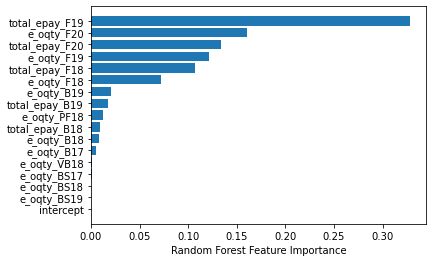

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.997
1258 140 32223 76


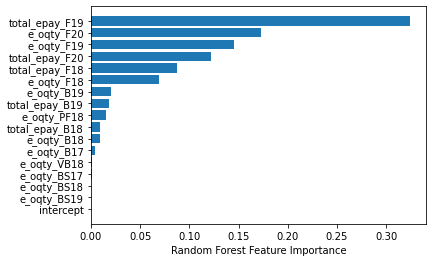

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.997
1264 167 32196 69


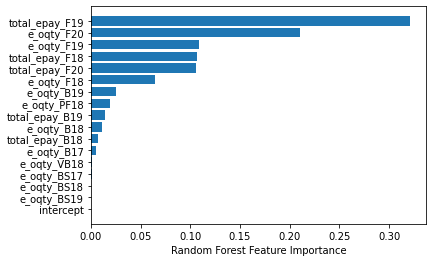

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.994
1261 179 32184 72


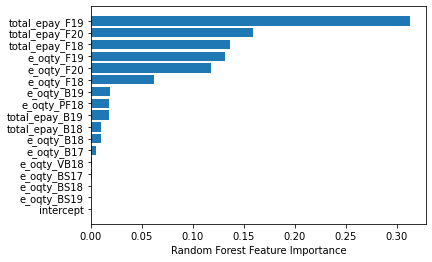

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.995
1253 148 32215 80


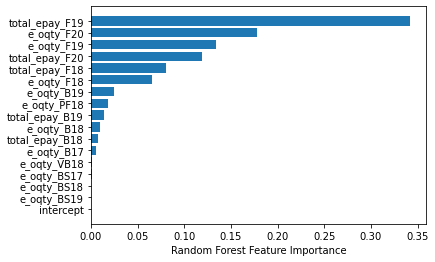

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.996
1267 173 32190 66


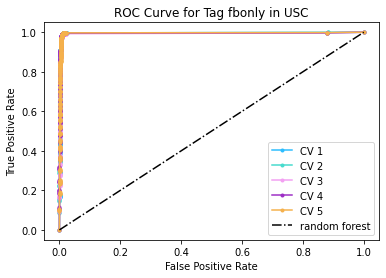

avg_sensitivity: 0.8866144114727785
avg_specificity: 0.9977506016607591
avg_f1 score: 0.9150910630906889
average_mse score: 0.006944406397992771
avg_auc_score: 0.9956829748159942


In [30]:
tags_dict = dict()
for tag in ['fbbb','fbonly']:
    print(tag)
    result = calculate_season_slm(tag,org)
#     print(result)
    if result!=0:
        tags_dict[tag] = result

# oklahoma

In [7]:
#oklahoma NkN & tyN
org = "OKLAHOMA"

In [8]:
# Load Account Data For a Specific Organization

account = pd.read_csv("acc_tags_set.csv")
account = account[account.org_id==org].copy()
account.drop(columns = ["nan_tag"], inplace = True)

interested_tags = set()
acc_tag_dict = defaultdict(int)
for i in range(len(account)):
    tag_list = ast.literal_eval(account.tags.iloc[i])
    for t in tag_list:
        acc_tag_dict[t]+=1
        interested_tags.add(t)
account_per_tag = []
for k,v in acc_tag_dict.items():
    account_per_tag.append({"tag":k,"counts":v })
account_per_tag = pd.DataFrame(account_per_tag)

In [9]:
ticket_season = pd.read_csv("oklahanoma_ticket_trans_item_event.csv")

In [10]:
ticket_season = ticket_season[ticket_season.org_id.isin([org])].copy()
ticket_orgs = ticket_season.org_id.unique()

In [11]:
useful_tags = []
error_tags = []
# method = "logit"

for i,tag in enumerate(interested_tags):
    if type(tag)==str and account_per_tag[account_per_tag.tag==tag].iloc[0]["counts"] >100:
        useful_tags.append(tag)

In [13]:
ticket_season_org = ticket_season[["account_id","org_id","season","total_epay",
                                   "e_oqty"]].groupby(["account_id","org_id",
                                                       "season"]).sum().reset_index()
ticket_season_org = ticket_season_org.pivot(index = ["account_id","org_id"], 
                           columns = ["season"],
                           values = ["total_epay","e_oqty"]).fillna(0)
ticket_season_org.columns = ["_".join(x) if x[0] not in ["account_id","org_id"] else x[0] for x in ticket_season_org.columns.ravel()]
temp = pd.merge(account,ticket_season_org, on = ["account_id","org_id"], how = "inner")
temp.fillna(0,inplace = True)

NkN
Selected Tag: NkN
old columns number: 146
total number of accounts labeled with tag: 2006
total number of accounts:  35808
percentage of tags: 0.05602100089365505
['total_epay_B17', 'total_epay_BB18', 'total_epay_BB19', 'total_epay_BB20', 'total_epay_BBR18', 'total_epay_BC17', 'total_epay_BC18', 'total_epay_BC19', 'total_epay_BN17', 'total_epay_BN18', 'total_epay_F17', 'total_epay_FB17', 'total_epay_FC17', 'total_epay_FS17', 'total_epay_FS18', 'total_epay_FS19', 'total_epay_HBB19', 'total_epay_KB18', 'total_epay_KC17', 'total_epay_MGY18', 'total_epay_MGY19', 'total_epay_MGY20', 'total_epay_MGYC19', 'total_epay_NPS18', 'total_epay_P18', 'total_epay_P19', 'total_epay_RVPK18', 'total_epay_RW20', 'total_epay_SB18', 'total_epay_SB19', 'total_epay_SB20', 'total_epay_SBR18', 'total_epay_SBR19', 'total_epay_SC17', 'total_epay_SC18', 'total_epay_SC19', 'total_epay_SCL17', 'total_epay_SCTG19', 'total_epay_SS17', 'total_epay_SS18', 'total_epay_SS19', 'total_epay_SS20', 'total_epay_TNR18', 'to

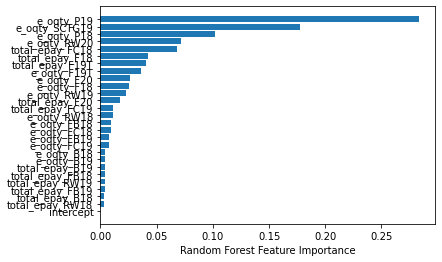

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.988
353 39 6722 49


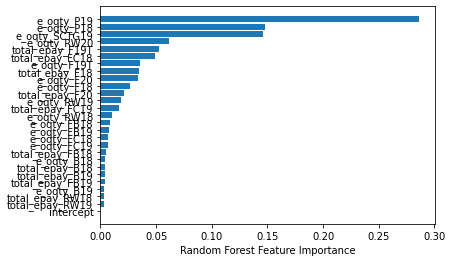

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.989
360 50 6711 41


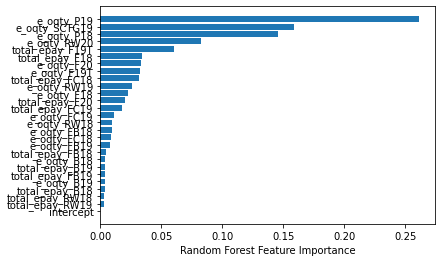

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.985
347 40 6720 54


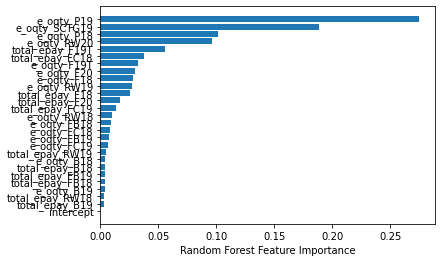

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.984
351 61 6699 50


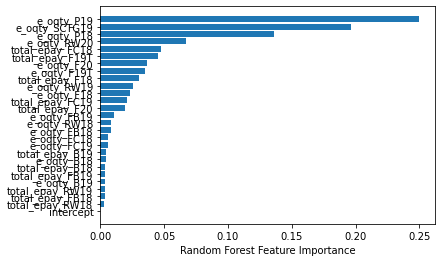

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.986
332 40 6720 69


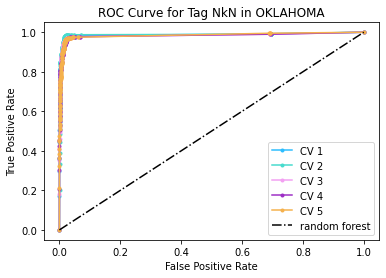

avg_sensitivity: 0.8839229354590415
avg_specificity: 0.9922294638202059
avg_f1 score: 0.876026370607172
average_mse score: 0.013767985570209317
avg_auc_score: 0.9863196162571786
tyN
Selected Tag: tyN
old columns number: 146
total number of accounts labeled with tag: 12429
total number of accounts:  35808
percentage of tags: 0.34710120643431636
['total_epay_B17', 'total_epay_BB18', 'total_epay_BB19', 'total_epay_BB20', 'total_epay_BBR18', 'total_epay_BC17', 'total_epay_BC18', 'total_epay_BC19', 'total_epay_BN17', 'total_epay_BN18', 'total_epay_F17', 'total_epay_FB17', 'total_epay_FC17', 'total_epay_FS17', 'total_epay_FS18', 'total_epay_FS19', 'total_epay_HBB19', 'total_epay_KB18', 'total_epay_KC17', 'total_epay_MGY18', 'total_epay_MGY19', 'total_epay_MGY20', 'total_epay_MGYC19', 'total_epay_NPS18', 'total_epay_P18', 'total_epay_P19', 'total_epay_RVPK18', 'total_epay_RW20', 'total_epay_SB18', 'total_epay_SB19', 'total_epay_SB20', 'total_epay_SBR18', 'total_epay_SBR19', 'total_epay_SC17',

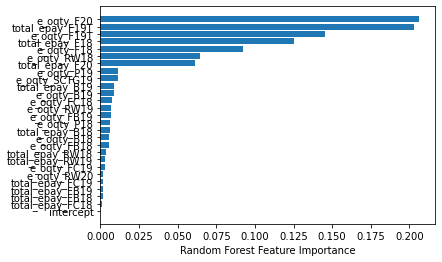

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.972
2304 158 4518 182


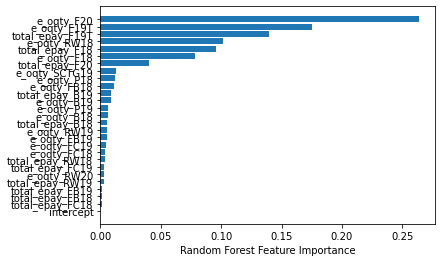

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.973
2323 172 4504 163


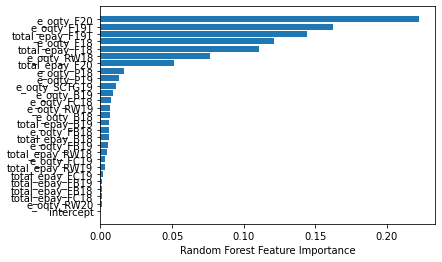

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.969
2299 182 4494 187


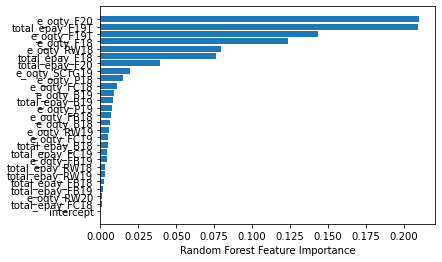

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.975
2314 182 4494 172


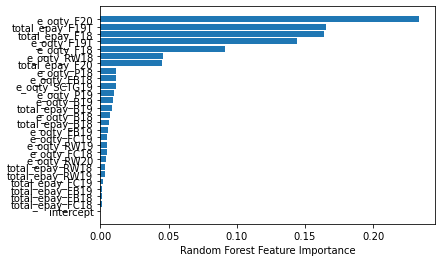

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.974
2322 163 4512 163


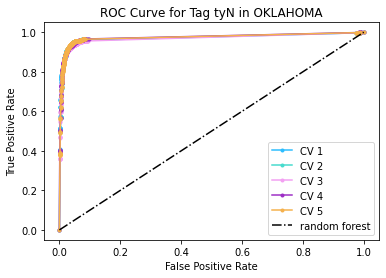

avg_sensitivity: 0.9310037823967026
avg_specificity: 0.9629346142111613
avg_f1 score: 0.9306180236634758
average_mse score: 0.04814551972779989
avg_auc_score: 0.9724567391322261


In [19]:
tags_dict = dict()
for tag in ['NkN', 'tyN']:
    print(tag)
    result = calculate_season_slm(tag,org)
#     print(result)
    if result!=0:
        tags_dict[tag] = result

## Format Result (optional)

In [ ]:
def format_model_result(tags_dict, sort_by_cols=["avg_sensitivity","avg_specificity"]):
    temp = []
    for k,v in tags_dict.items():
        tags_dict[k]["tag"]=k
        temp.append(tags_dict[k])
    tags_dict = pd.DataFrame(temp)
    return tags_dict.sort_values(by = sort_by_cols,ascending = False)

## Show Result

In [ ]:
format_model_result(tags_dict, ["avg_sensitivity","avg_specificity"])